# Import Graph2Net

In [2]:
from graph2net.utils import load_data,gen_and_validate
from graph2net.graph_generators import build_matrix,gen_cell,show_matrix,stack_matrix
from graph2net.ops import *

# ResNet Demo

In [3]:
print_operations()

0 : zero
1 : identity
2 : double_channel
3 : halve_channel
4 : avg_pool_3x3
5 : max_pool_3x3
6 : max_pool_5x5
7 : max_pool_7x7
8 : 1x7_7x1_conv
9 : 1x3_3x1_conv
10 : dil_conv_3x3
11 : conv_1x1
12 : conv_3x3
13 : sep_conv_3x3
14 : sep_conv_5x5
15 : sep_conv_7x7


In [4]:
resnet = build_matrix([
    [0,1,"conv_3x3"],
    [1,2,"conv_3x3"],
    [2,3,"conv_3x3"],
    [3,4,"conv_3x3"],
    [0,2,"identity"],
    [2,4,"identity"],
    [4,5,"max_pool_3x3"],
])
resnet

array([[ 0., 12.,  1.,  0.,  0.,  0.],
       [ 0.,  0., 12.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12.,  1.,  0.],
       [ 0.,  0.,  0.,  0., 12.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

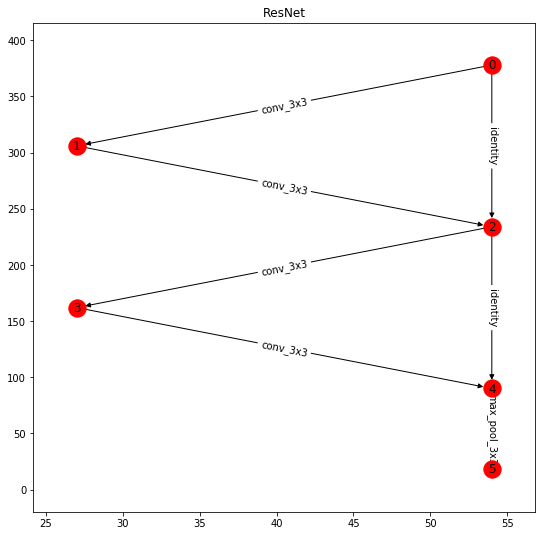

In [5]:
show_matrix(resnet,"ResNet")

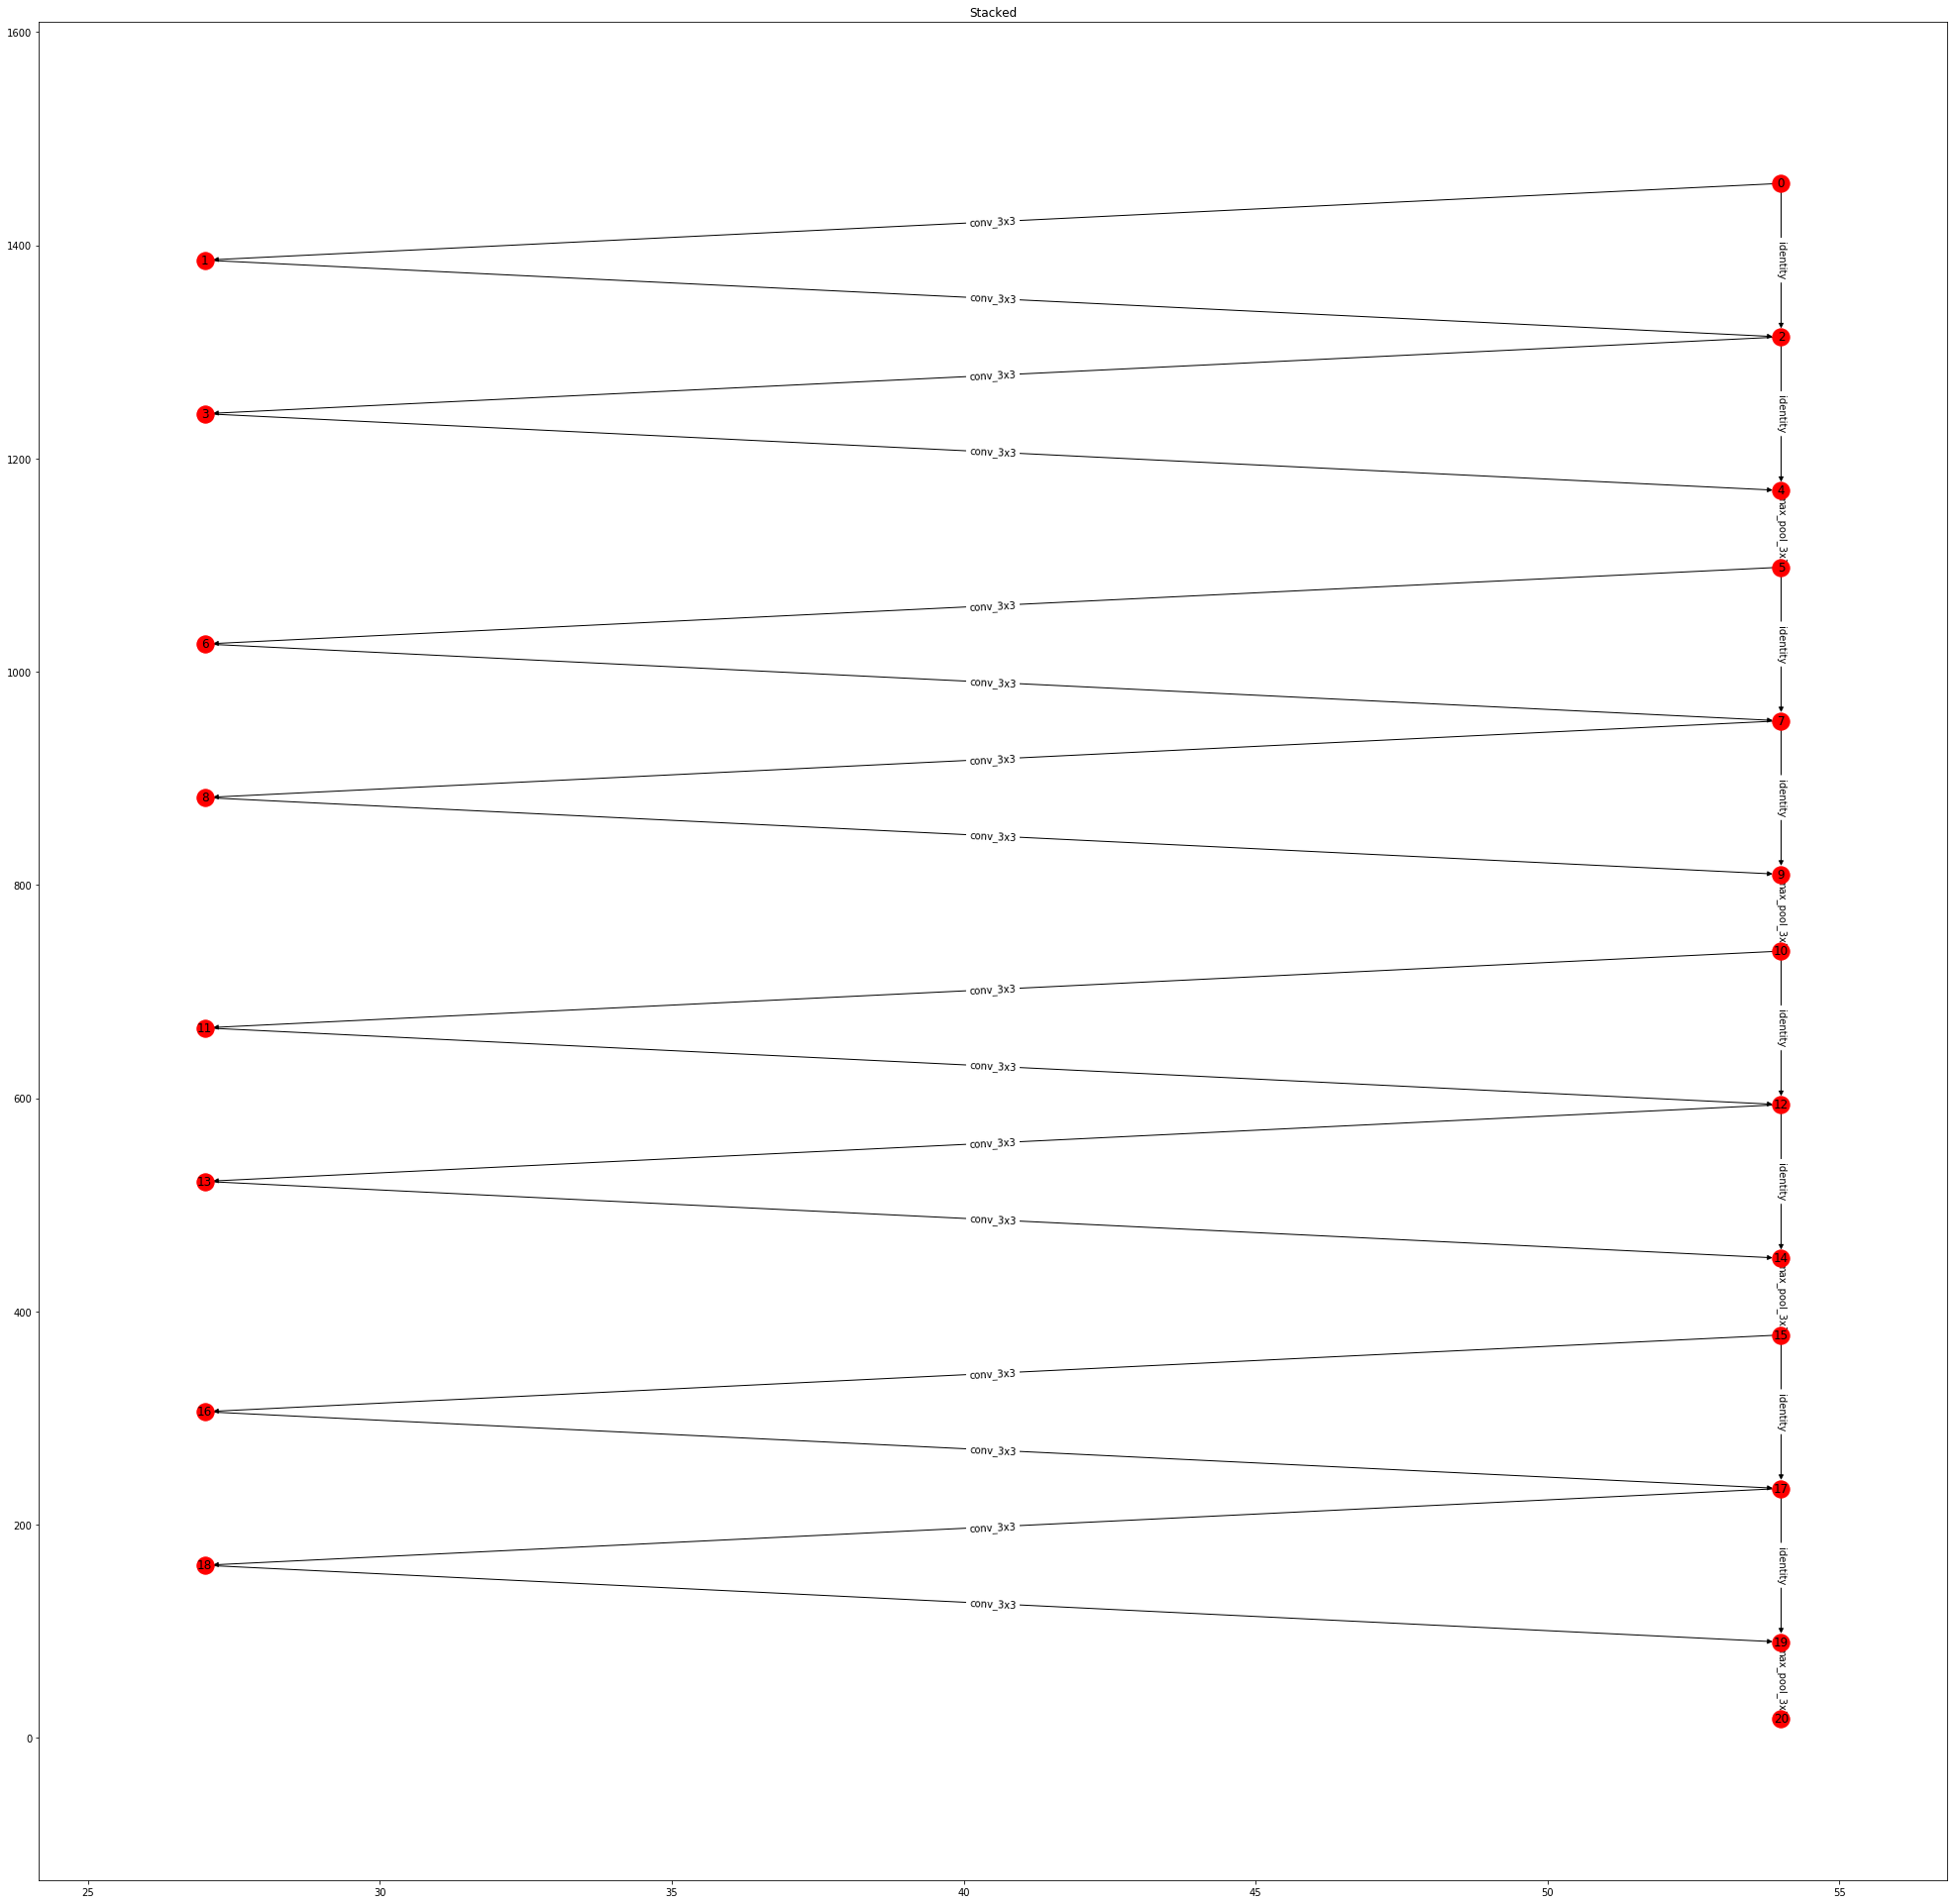

In [6]:
show_matrix(stack_matrix(resnet,4),"Stacked")

In [7]:
p=gen_and_validate(resnet,"ResNet",cell_count=4,verbose=False,keep_model=False)

Validating model...[SUCCESS]


# Random Cells

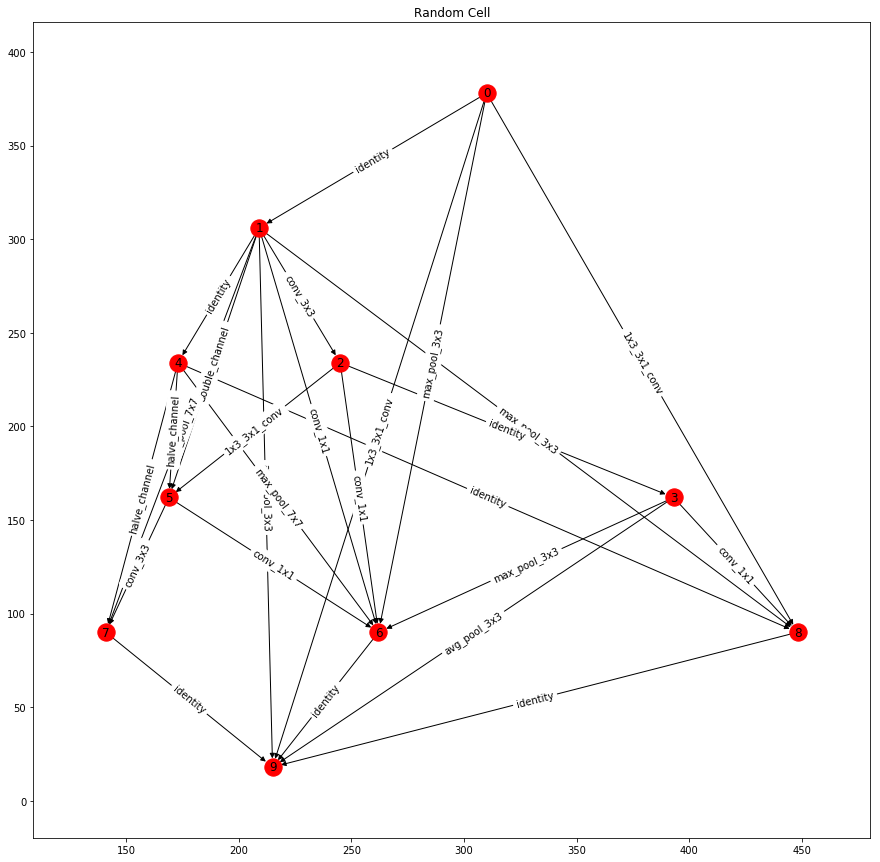

Validating model...[SUCCESS]


In [11]:
random_cell=gen_cell(10,sparsity_thresh=.5)
show_matrix(random_cell,"Random Cell")
p=gen_and_validate(random_cell,"Random Cell",cell_count=4,verbose=False,keep_model=False)

In [9]:
random_cell

array([[ 0.,  1.,  1., 10.,  1.,  4.,  8.,  0., 12.,  3.],
       [ 0.,  0.,  4.,  0.,  0.,  0.,  2.,  0.,  0.,  6.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 12.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  6.,  5.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 12.,  1.,  1.,  6.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 11.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])